In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from DataGenerator import *
from Competition import *
from config import *

In [2]:
BN_EO = initialize_BN()
dataset = BN_EO.simulate(n_samples=50000, seed=SEED)

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
dataset

,SAT,COLLEGE,INTERN,SES,SEX,JOB,CGPA,SCHOOL
0,2,1,1,2,1,1,2,1
1,1,0,1,2,1,0,2,2
2,1,0,1,0,1,0,2,1
3,2,0,0,1,1,0,0,1
4,2,0,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,1,0
49996,1,1,1,2,0,1,1,1
49997,0,1,1,1,0,1,1,0
49998,1,1,1,2,1,1,2,1


In [4]:
C1_label = 'COLLEGE'
C1_features = ['SES', 'SEX', 'SAT', 'SCHOOL']
C1 = Competition(dataset, C1_features, C1_label, ['SEX', 'SES'], [0,0])

In [5]:
C2_label = 'INTERN'
C2_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA']
C2 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [6]:
C3_label = 'JOB'
C3_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA','INTERN']
C3 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [7]:
X_train, y_train, X_test, y_test, X_val, y_val = C1.create_train_test_val_split(SEED=44)
X_train.shape, X_test.shape, X_val.shape

((30000, 4), (10000, 4), (10000, 4))

In [8]:
C2.create_train_test_val_split(SEED=44)
C3.create_train_test_val_split(SEED=44)

(       SES  SEX  SAT  SCHOOL  COLLEGE  CGPA
 7180     1    0    2       0        1     0
 23110    1    0    1       0        1     1
 39329    1    1    0       2        1     2
 319      2    1    1       1        0     2
 7916     2    0    1       0        1     1
 ...    ...  ...  ...     ...      ...   ...
 16848    2    0    2       0        1     1
 45072    1    1    0       1        0     2
 19667    2    1    2       1        1     0
 6728     2    0    2       1        1     1
 7086     0    1    0       2        1     2
 
 [30000 rows x 6 columns],
 7180     1
 23110    1
 39329    1
 319      1
 7916     1
         ..
 16848    1
 45072    0
 19667    1
 6728     1
 7086     1
 Name: INTERN, Length: 30000, dtype: int64,
        SES  SEX  SAT  SCHOOL  COLLEGE  CGPA
 49457    1    1    2       2        1     2
 20706    1    0    2       0        1     0
 46059    2    1    1       2        0     1
 38076    2    1    2       2        1     2
 8394     2    1    2       2 

In [9]:
for i in C1.test_groups.keys():
    print(i, C1.test_groups[i].shape[0]/C1.X_test.shape[0])

SEX_SES_priv 0.1191
SEX_SES_dis 0.313
SEX_priv 0.6057
SEX_dis 0.3943
SES_priv 0.2004
SES_dis 0.7996


In [10]:
best_models = {}
#for model_name in model_specs.keys():
for model_name in ['lr']:
    print(model_name)
    search = GridSearchCV(model_specs[model_name]["base_model"], model_specs[model_name]["params"], cv=5, n_jobs=-1, verbose=True)
    model = search.fit(X_train, y_train)
    best_models[model_name] = model.best_estimator_
    
best_models

lr
Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'lr': LogisticRegression(C=1, max_iter=200, random_state=111, solver='newton-cg')}

In [11]:
best_model = best_models['lr']
res_df = C1.fit_base_model(best_model)

In [12]:
res2_df = C2.fit_base_model(best_model)

In [13]:
res3_df = C3.fit_base_model(best_model)

In [14]:
C1.X_train

,SES,SEX,SAT,SCHOOL
7180,1,0,2,0
23110,1,0,1,0
39329,1,1,0,2
319,2,1,1,1
7916,2,0,1,0
...,...,...,...,...
16848,2,0,2,0
45072,1,1,0,1
19667,2,1,2,1
6728,2,0,2,1


In [15]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [16]:
def mse(y_true, y_pred, sample_weights=None):
    return np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weights)

In [89]:
def C_forward_linear(X, Y):
    # SES, SEX, SAT, SCHOOL
    # 0 is priv
    beta = [-0.5, -0.2, -0.6, -0.1]
    beta_y = -0.2
    return sigmoid(np.matmul(X,beta)+beta_y*Y)

In [92]:
class CustomLinearModel:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with custom regularization
    """
    def __init__(self, loss_function=mse, C_forward=C_forward_linear,
                 X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.0015):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.C_forward_fuction = C_forward
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        
        self.X = X
        self.Y = Y
            
    def predict(self, X):
        prediction = sigmoid(np.matmul(X, self.beta))
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y, sample_weights=self.sample_weights
        )
        print("model error: ", error)
        return(error)
    
    def C2_error(self):
        error = np.linalg.norm((self.C_forward_fuction(self.X, self.predict(self.X))), ord=1)
        print("forward error: ", error)
        return(error)
    
    def custom_foward_loss(self, beta):
        self.beta = beta
        return (self.model_error() + (self.regularization/self.C2_error()))
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta)**2))
    
    def fit(self, maxiter=250):        
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([0.1]*self.X.shape[1])
        else: 
            # Use provided initial values
            pass
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
            
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='Nelder-Mead', options={'maxiter': maxiter})
        self.beta = res.x
        self.beta_init = self.beta

model error:  0.22416228605088212
model error:  0.22389522562215897
model error:  0.22407747767413796
model error:  0.2238725718190819
model error:  0.22403022144081625
model error:  0.2237773354968321
model error:  0.2235894728574053
model error:  0.22361820519103823
model error:  0.22346064037785693
model error:  0.2231843189958959
model error:  0.22323998265948197
model error:  0.22295783950034137
model error:  0.2225271799629368
model error:  0.22265527723795803
model error:  0.22223850722906185
model error:  0.22161555088101278
model error:  0.2217722474558722
model error:  0.22117817030063533
model error:  0.22031817314814228
model error:  0.22051343730041695
model error:  0.21973712044761973
model error:  0.2186477496991713
model error:  0.2188889591224585
model error:  0.21800893711990083
model error:  0.2169905786991671
model error:  0.21714393846913738
model error:  0.21641919353609204
model error:  0.21610400218156775
model error:  0.21614811517446902
model error:  0.2166640

model error:  0.21640628166852743
model error:  0.21805720918714708
model error:  0.2162676674573942
model error:  0.21636574750039156
model error:  0.21674150563824268
model error:  0.21618308094943822
model error:  0.21646879836664742
model error:  0.21618465197077796
model error:  0.21613706845764769
model error:  0.21637776890084667
model error:  0.21611903361649368
model error:  0.216048164189557
model error:  0.2160005050551869
model error:  0.21601766380055346
model error:  0.21605731080675025
model error:  0.21594977276610736
model error:  0.21589732274065784
model error:  0.21587800704568963
model error:  0.21583611753071613
model error:  0.21585656890175106
model error:  0.21576983331039545
model error:  0.21574907252197537
model error:  0.21567825547604347
model error:  0.21569062703371164
model error:  0.21576204391082032
model error:  0.2159964974500978
model error:  0.21574518976149798
model error:  0.21566771350344013
model error:  0.2157199410409715
model error:  0.2157

model error:  0.2156477813258019
model error:  0.21563725824568106
model error:  0.21563549255626668
model error:  0.21562615824492848
model error:  0.2156173114091362
model error:  0.2156008102484495
model error:  0.215605103061617
model error:  0.21559009493876682
model error:  0.2155940810538399
model error:  0.21560415974425942
model error:  0.21558317663345303
model error:  0.21559617017955007
model error:  0.21558658611988196
model error:  0.21557993344080506
model error:  0.21559491144104748
model error:  0.21557777533483688
model error:  0.2155996487381406
model error:  0.21557165549881724
model error:  0.21558281414837205
model error:  0.2155802968577036
model error:  0.21557174089318523
model error:  0.2155823968173826
model error:  0.2155724161504262
model error:  0.21559060762307802
model error:  0.21557073315830005
model error:  0.21556115037716844
model error:  0.21555933359199336
model error:  0.21557296814161328
model error:  0.21556587739771443
model error:  0.21556449

model error:  0.21562484396008774
model error:  0.2156102365605938
model error:  0.21559770742357556
model error:  0.21559987787710985
model error:  0.2155953822891662
model error:  0.21560285636835136
model error:  0.21559484567668832
model error:  0.21558948092884167
model error:  0.21558879109645623
model error:  0.21560727263145033
model error:  0.21559104947520175
model error:  0.21558559889142986
model error:  0.2155888555180081
model error:  0.21558535410282464
model error:  0.21559242405476245
model error:  0.21558302521246786
model error:  0.2155862667687508
model error:  0.21559666145138726
model error:  0.21559218629356297
model error:  0.21559538471536277
model error:  0.2155761178189548
model error:  0.21556855647384832
model error:  0.21559324239718997
model error:  0.21557236537496371
model error:  0.21558088425673938
model error:  0.21556172149896516
model error:  0.21555012321971384
model error:  0.215559423699836
model error:  0.21555543283843942
model error:  0.21554

model error:  0.2155047051043343
model error:  0.21562187357329426
model error:  0.21567412053127738
model error:  0.2155983678477153
model error:  0.21560433032142398
model error:  0.21559252087424183
model error:  0.21556053927348445
model error:  0.21554467020167722
model error:  0.21557041118699571
model error:  0.21558575805611363
model error:  0.21565018487620236
model error:  0.21556411335780085
model error:  0.2155744164447226
model error:  0.21552231969933958
model error:  0.2155278595326456
model error:  0.21556918100273142
model error:  0.21553649803950273
model error:  0.21556312079903442
model error:  0.21560805492680143
model error:  0.21554246191846213
model error:  0.21556167430767217
model error:  0.21555998787376304
model error:  0.21555490887974496
model error:  0.2155609361135668
model error:  0.21558467496418438
model error:  0.21555259883168568
model error:  0.21555942397023276
model error:  0.2155616228416203
model error:  0.21554876584582044
model error:  0.2155

model error:  0.22414211796870334
model error:  0.22427955573169014
model error:  0.2243042264778812
model error:  0.22453277509310574
model error:  0.22486861432816027
model error:  0.22460537227935548
model error:  0.2248400925965968
model error:  0.22507415895724053
model error:  0.225598825337812
model error:  0.22549568014331547
model error:  0.2261852329547417
model error:  0.22724936015844743
model error:  0.22674529272097962
model error:  0.22779944399684587
model error:  0.22832050679554317
model error:  0.23031948662252782
model error:  0.23013819453246886
model error:  0.23272883532406802
model error:  0.23355963283583192
model error:  0.2373902257376897
model error:  0.2360857726892098
model error:  0.2321321931634947
model error:  0.23187533394929064
model error:  0.235859569662097
model error:  0.23883051590806195
model error:  0.23384140873144407
model error:  0.23284991291771415
model error:  0.2365201073808118
model error:  0.2381453709312982
model error:  0.2307225089

model error:  0.24616819973352552
model error:  0.24834997722835525
model error:  0.2445139588578361
model error:  0.24838680193277493
model error:  0.2507334824902471
model error:  0.2520266215726034
model error:  0.2475801083140598
model error:  0.2493348138186154
model error:  0.24858931942499235
model error:  0.24597407850609646
model error:  0.24950806073729448
model error:  0.24834924839508352
model error:  0.24859454690426247
model error:  0.2487452940518065
model error:  0.24865405507150698
model error:  0.24721665961862188
model error:  0.24778194553570684
model error:  0.24771838548710662
model error:  0.24836914282275538
model error:  0.249128516496155
model error:  0.247963068458105
model error:  0.2477033944928935
model error:  0.24841454537272337
model error:  0.24767225424011904
model error:  0.24836256157428022
model error:  0.2487757565601238
model error:  0.2483881281880231
model error:  0.2483736363485022
model error:  0.24778424850582448
model error:  0.248526473229

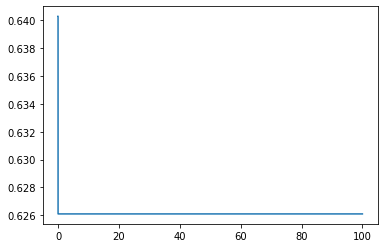

In [94]:
lambda_range = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2,5 ,10,50,100]
acc = []
for lambda_ in lambda_range:
    c1_fair = CustomLinearModel(X=C1.X_train.values, Y=C1.y_train.values, regularization=lambda_)
    c1_fair.fit(maxiter=500)
    c1_fair_preds = np.round(c1_fair.predict(C1.X_test.values))
    acc.append(accuracy_score(C1.y_test.values, c1_fair_preds))
    
print(c1_fair.beta)

plt.plot(lambda_range, acc)